In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gc

In [2]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
import csv

In [3]:
with open('hansard-speeches-post2010-lemmatized-agg-ngrams.pkl', 'rb') as f:
    df = pickle.load(f)

# Exploring Ieff and top topic p distributions

In [4]:
def make_probs(size, n_att_topics, p_topics=.6):
    if size < n_att_topics:
        return np.array([])
    else:
        return np.concatenate([np.repeat(p_topics/n_att_topics, n_att_topics), 
                               np.repeat( (1-p_topics)/(size-n_att_topics), (size-n_att_topics) )])

## 90

### Load files

In [248]:
N = 90

with open(f'topic-models/coarse/doc-topics/lda_mallet_{N}_doc_topics.pkl', 'rb') as f:
    dt = pickle.load(f)
    
with open(f'topic-models/coarse/lda_mallet_{N}.pkl', 'rb') as f:
    lda = pickle.load(f)

In [6]:
dt.shape

(98174, 90)

## Plot Ieff distribution

In [15]:
from scipy.stats import entropy

def plot_Ieff(dt, n_top=5, att=.75, bins=100):
    S = entropy(dt, base=2, axis=1)
    Ieff = 2**S
    
    syn_probs = make_probs(dt.shape[1], 5, .75)
    syn_Ieff = 2**entropy(syn_probs, base=2)
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(Ieff, bins=bins)
    ax.axvline(syn_Ieff, c='r', alpha=0.5)
    plt.show()
    
    return Ieff

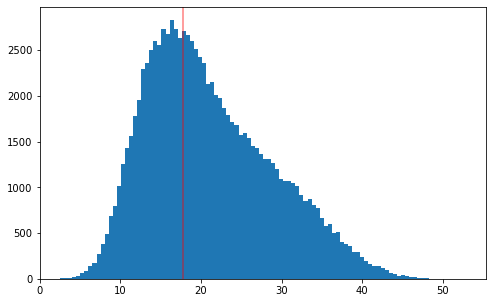

In [16]:
Ieff = plot_Ieff(dt)

In [101]:
def review_doc(ind, n_top_p=3, n_topics=5):
    print(f'doc id: {ind}', '\n')

    print('Ieff:', Ieff[ind], '\n')
    
    print(f'top {n_top_p} topic ps:', np.sum(np.sort(dt[ind])[::-1][:n_top_p]), '\n')

    print('Largest doc topic probs', np.sort(dt[ind])[::-1][:12], '\n')

    for i, topic_id in enumerate(np.argsort(dt[ind])[::-1][:n_topics]):
        print(np.around( np.sort(dt[ind])[::-1][i], 3 ), topic_id)
        print(lda.print_topic(topic_id))
        print('\r')

    print(df.iloc[ind].speech)

In [36]:
len(np.where(Ieff < 10)[0])

4044

In [35]:
ind = np.random.choice(np.where(Ieff < 10)[0])
review_doc(ind)

doc id: 273 

Ieff: 9.840915761812315 

top 3 topic ps: 0.6385767790262172 

Largest doc topic probs [0.54057428 0.05181024 0.04619226 0.04619226 0.0349563  0.02372035
 0.02372035 0.02372035 0.01810237 0.01810237 0.01248439 0.01248439] 

0.541 89
0.143*"school" + 0.049*"education" + 0.025*"child" + 0.024*"teacher" + 0.019*"pupil" + 0.019*"academy" + 0.012*"parent" + 0.009*"free" + 0.008*"teach" + 0.008*"standard"

0.052 48
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

0.046 36
0.038*"regulation" + 0.024*"power" + 0.020*"ensure" + 0.018*"legislation" + 0.013*"require" + 0.012*"act" + 0.012*"standard" + 0.011*"provide" + 0.011*"set" + 0.011*"protection"

0.046 62
0.046*"review" + 0.027*"consultation" + 0.025*"information" + 0.025*"publish" + 0.018*"decision" + 0.017*"report" + 0.016*"assessment" + 0.015*"response" + 0.014*"impact" + 0.014*"department"

0.035 9

## Plot topic p distributions

In [48]:
dt.shape

(98174, 90)

In [37]:
def topic_i_p(dt,i,j=None):
    if j is not None:
        return np.sum([topic_i_p(dt, n) for n in np.arange(i,j)], axis=0)
    else:
        return np.sort(dt, axis=1)[:, ::-1][:,i]

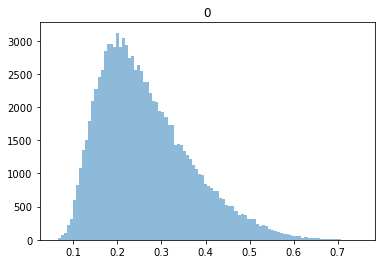

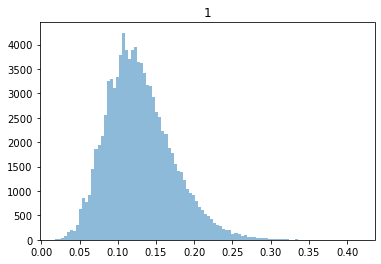

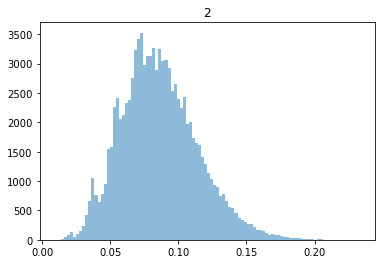

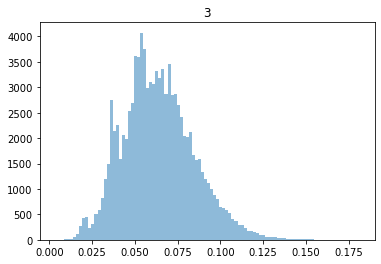

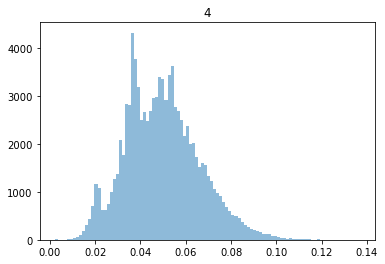

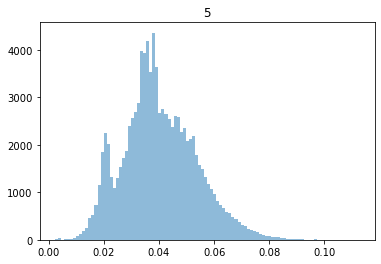

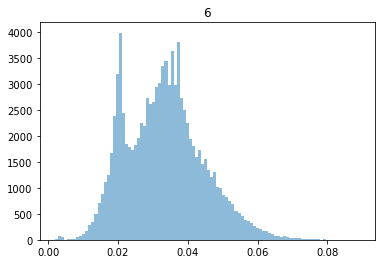

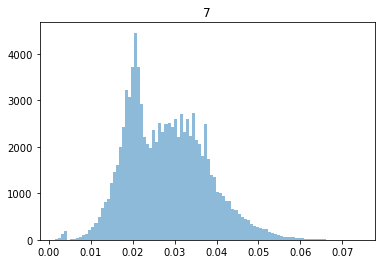

In [38]:
for i in range(8):
    plt.hist(topic_i_p(dt, i), bins=100, alpha=0.5)
    plt.title(i)
    plt.show()

* changing shape of distribution (growing peak around 0.02 - lda averages small amount over many topics, so all end up with the around the same small value) 
* shape change visible in 2, strong in 3
* motivates decision to take sum of no more than top 3 topic probabilities (from 0 up to and including 2)

In [39]:
def get_suffix(n):
    if n==1:
        return 'st'
    elif n==2:
        return 'nd'
    elif n==3:
        return 'rd'
    else:
        return 'th'

In [224]:
def plot_top_p_hist(dt, top_p=3, bins=100, title=''):
    for i in range(top_p):
        plt.hist(topic_i_p(dt,i), bins=bins, alpha=0.5, label=f'{i}{get_suffix(i)}')
    plt.hist(topic_i_p(dt,0,top_p), bins=bins, alpha=0.5, label=f'sum of top {top_p}')
    plt.xlabel(f'document topic probability')
    plt.ylabel('frequency')
    plt.legend(title='nth highest doc prob')
    plt.title(title)
#     plt.show()

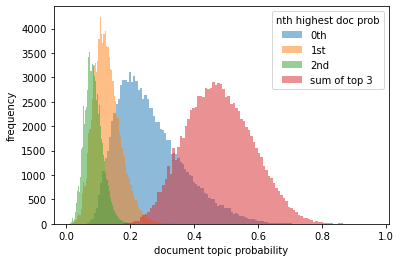

In [43]:
plot_top_p_hist(dt, 3)

In [50]:
len(np.where(topic_i_p(dt,0,3) > .5)[0])/len(df)

0.41197262004196633

In [55]:
ind = np.random.choice(np.where(topic_i_p(dt,0,3) > 0.8)[0])
# ind = np.random.choice(np.where(Ieff > 40)[0])
review_doc(ind, 3)

doc id: 15746 

Ieff: 4.7594678244338136 

top 3 topic ps: 0.8955094991364422 

Largest doc topic probs [0.4228555  0.40213011 0.07052389 0.00834773 0.00834773 0.00834773
 0.00575705 0.00575705 0.00316638 0.00316638 0.00316638 0.00316638] 

0.423 21
0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

0.402 25
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

0.071 88
0.047*"number" + 0.036*"figure" + 0.031*"increase" + 0.018*"report" + 0.017*"cost" + 0.016*"month" + 0.010*"fact" + 0.010*"period" + 0.010*"level" + 0.010*"fall"

0.008 69
0.053*"election" + 0.049*"vote" + 0.026*"register" + 0.025*"referendum" + 0.023*"party" + 0.017*"system" + 0.016*"political" + 0.014*"constituency" + 0.013*"campaign" + 0.012*"voter"

0.008 48
0.185*"bill" + 0.071

## Plot Ieff, no. lemmas, and sum of topic probs against each other

In [56]:
length = df.lemmas_ngrams.apply(len).values

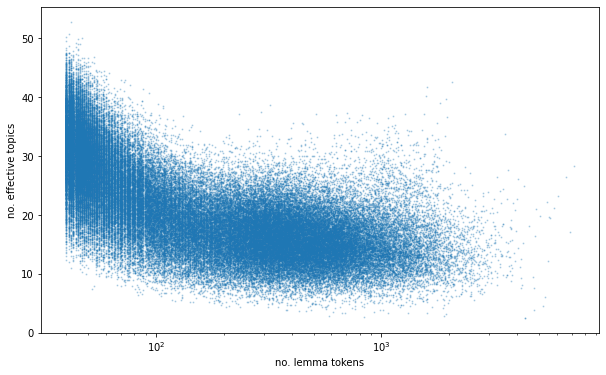

In [57]:
plt.figure(figsize=(10,6))
plt.scatter(length, Ieff, s=1, alpha=0.25)
plt.xlabel('no. lemma tokens')
plt.ylabel('no. effective topics')
plt.xscale('log')
# plt.yscale('log')

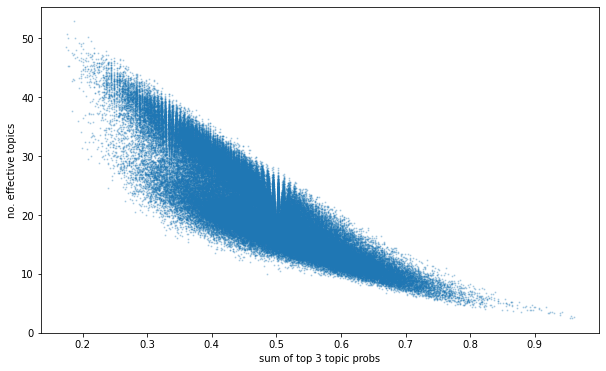

In [59]:
plt.figure(figsize=(10,6))
plt.scatter(topic_i_p(dt,0,3), Ieff, s=1, alpha=0.25)
plt.xlabel('sum of top 3 topic probs')
plt.ylabel('no. effective topics')
plt.show()
# plt.xscale('log')
# plt.yscale('log')

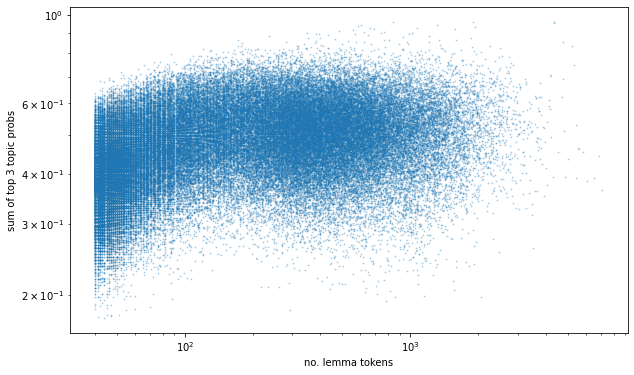

In [60]:
plt.figure(figsize=(10,6))
plt.scatter(length, topic_i_p(dt,0,3), s=1, alpha=0.25)
plt.xlabel('no. lemma tokens')
plt.ylabel('sum of top 3 topic probs')
plt.xscale('log')
plt.yscale('log')

### Investigating "stop-topics"

### 90

I compiled the following "stop-topics" (non-topical LDA topics) by examining speeches at the extremes of the I_eff and top-3-topic-p-sum distributions, using my own domain knowledge of politics and parliament and by examining multiple speeches corresponding strongly to each of the topics.

25
* 0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

21
* 0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

5
* 0.074*"debate" + 0.035*"important" + 0.031*"hear" + 0.024*"speak" + 0.022*"hope" + 0.018*"today" + 0.016*"talk" + 0.016*"speech" + 0.013*"mention" + 0.012*"thing"

48
* 0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

9
* 0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

83
* 0.033*"mr" + 0.023*"south" + 0.019*"north" + 0.018*"debate" + 0.016*"speak" + 0.014*"speech" + 0.013*"hear" + 0.012*"west" + 0.011*"mention" + 0.011*"east"
* corresponds to lists of names and places, primarily - e.g. MPs reading out names of individuals from their constituency killed in conflict or disaster.

82
* 0.041*"petition" + 0.020*"recall" + 0.020*"urge" + 0.019*"constituent" + 0.017*"sign" + 0.017*"state" + 0.017*"commons" + 0.016*"mr" + 0.013*"john" + 0.011*"constituency"

19
* 0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*"ensure" + 0.028*"raise" + 0.025*"absolutely" + 0.019*"question" + 0.016*"make" + 0.016*"continue" + 0.015*"happy"

27
* 0.035*"thing" + 0.022*"problem" + 0.019*"happen" + 0.014*"talk" + 0.013*"lot" + 0.011*"find" + 0.010*"money" + 0.009*"deal" + 0.009*"idea" + 0.009*"sort"

In [147]:
stop_topics = [25, 21, 5, 48, 9, 83, 82, 19, 27]

## Identify "stop-speeches"

define a "stop-speech" as one where
1) the sum of its stop-topic probabilities is greater than 0.4; and
2) its most likely topic is a stop-topic

In [218]:
# generate stop-speech indices in df/dt

stop_topic_sum = np.sum(dt[:,stop_topics], axis=1)
top_topic = np.argmax(dt, axis=1)

stopspeech_inds = np.where((stop_topic_sum > 0.4) & (np.isin(top_topic, stop_topics)))[0]
print(len(stopspeech_inds))

4467


In [219]:
# find remaining indices (not stop-speeches)
non_stopspeech_inds = np.array(list(set(np.arange(dt.shape[0])) - set(stop_topic_speech_inds)))

In [220]:
# sample stop-speeches
ind = np.random.choice(stopspeech_inds)
review_doc(ind)

doc id: 39127 

Ieff: 8.996690433041561 

top 3 topic ps: 0.678294573643411 

Largest doc topic probs [0.57105943 0.06524548 0.04198966 0.03036176 0.0245478  0.0245478
 0.01873385 0.01873385 0.0129199  0.0129199  0.0129199  0.0129199 ] 

0.571 9
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

0.065 83
0.033*"mr" + 0.023*"south" + 0.019*"north" + 0.018*"debate" + 0.016*"speak" + 0.014*"speech" + 0.013*"hear" + 0.012*"west" + 0.011*"mention" + 0.011*"east"

0.042 43
0.036*"pub" + 0.018*"industry" + 0.016*"gambling" + 0.013*"problem" + 0.011*"beer" + 0.011*"company" + 0.010*"code" + 0.009*"tie" + 0.008*"bet" + 0.008*"levy"

0.03 19
0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*"ensure" + 0.028*"raise" + 0.025*"absolutely" + 0.019*"question" + 0.016*"make" + 0.016*"continue" + 0.015*"happy"

0.025 30
0.075*"eu" + 0.044*"uk" + 0.036*"trade" + 0.023*"europe

In [222]:
print(np.min(df.lemmas_ngrams.apply(len).values))
print(np.max(df.lemmas_ngrams.apply(len).values))

40
7122


## Compare stop-speeches to others

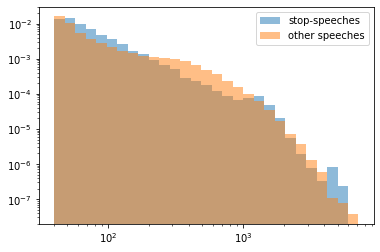

In [197]:
logbins = np.logspace(np.log10(40), np.log10(7150), 30)
plt.hist(df.iloc[stop_topic_speech_inds].lemmas_ngrams.apply(len).values, bins=logbins, alpha=0.5, label='stop-speeches', density=True)
plt.hist(df.iloc[non_stop_topic_speech_inds].lemmas_ngrams.apply(len).values, bins=logbins, alpha=0.5, label='other speeches', density=True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

 suggests stop-speeches more likely to have extreme length (v short or v long) than other speeches - small difference on this plot, but bear in mind log scale

In [117]:
low_max_p_topics = np.where(np.max(dt, axis=0) > 0.65)[0]
for i in low_max_p_topics:
    print(i, np.around(np.max(dt, axis=0)[i], 3))
    print(lda.print_topic(i))
    print('\n')

3 0.712
0.015*"russia" + 0.014*"action" + 0.013*"syria" + 0.013*"iraq" + 0.012*"security" + 0.012*"military" + 0.009*"force" + 0.009*"russian" + 0.009*"nato" + 0.008*"world"


9 0.741
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"


11 0.72
0.030*"transport" + 0.025*"train" + 0.023*"rail" + 0.020*"service" + 0.018*"line" + 0.017*"railway" + 0.017*"bus" + 0.016*"project" + 0.015*"passenger" + 0.015*"station"


12 0.668
0.048*"price" + 0.043*"market" + 0.040*"energy" + 0.032*"consumer" + 0.028*"bill" + 0.025*"company" + 0.017*"cost" + 0.014*"customer" + 0.013*"competition" + 0.012*"deal"


15 0.654
0.053*"tax" + 0.030*"company" + 0.023*"hmrc" + 0.019*"pay" + 0.016*"uk" + 0.011*"tax_avoidance" + 0.010*"rule" + 0.009*"profit" + 0.009*"billion" + 0.008*"money"


17 0.66
0.040*"defence" + 0.026*"armed_force" + 0.017*"force" + 0.017*"service" + 0.015*"afghanistan" + 0.013*

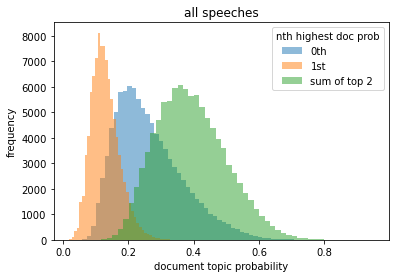

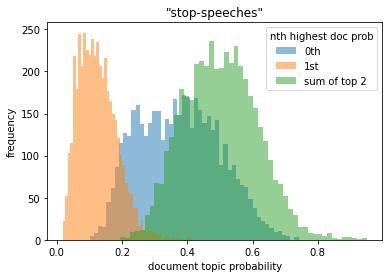

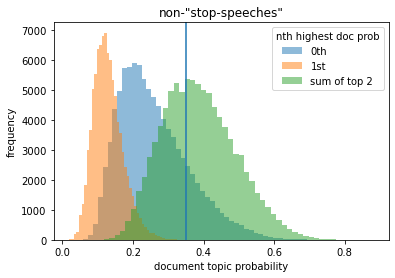

In [230]:
plot_top_p_hist(dt, 2, 50, title='all speeches')
plt.show()

plot_top_p_hist(dt[stopspeech_inds], 2, 50, title='"stop-speeches"')
plt.show()

plot_top_p_hist(dt[non_stopspeech_inds], 2, 50, title='non-"stop-speeches"')
plt.axvline(0.35)
plt.show()

Distribution of highest probability values further right for stop-speeches. Opposite is true for the distribution of the second highest probability values.

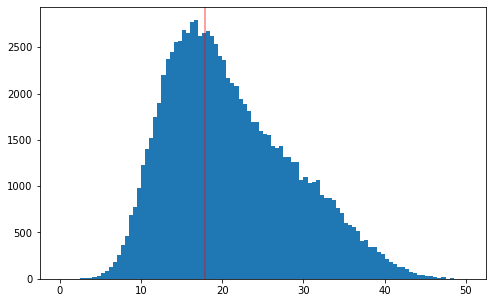

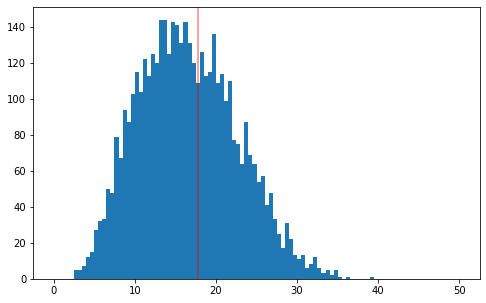

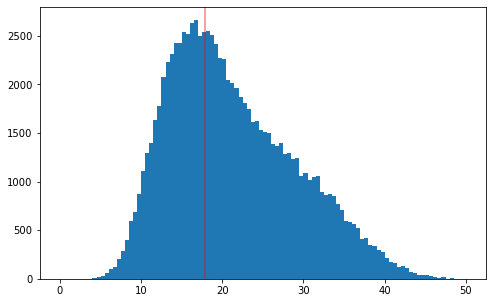

array([24.1856649 , 28.89949138, 32.31643585, ..., 19.96906395,
       19.87216853, 18.12059601])

In [210]:
bins = np.linspace(0,50,101)
plot_Ieff(dt, n_top=5, att=.75, bins=bins)
plot_Ieff(dt[stopspeech_inds], n_top=5, att=.75, bins=bins)
plot_Ieff(dt[non_stopspeech_inds], n_top=5, att=.75, bins=bins)

# Filter speeches

## 1) retaining non-stop-speeches with top-2 topic sum above threshold of 0.35

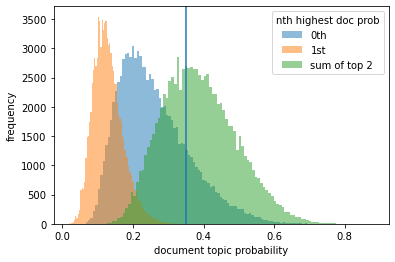

In [281]:
plot_top_p_hist(dt[non_stopspeech_inds],2)
plt.axvline(0.35)
plt.show()

In [284]:
t = 0.3
# the non-stop-speech indices corresponding to non-stop-speeches with a top-2 topic sum above t
filter_inds = non_stopspeech_inds[np.where(topic_i_p(dt[non_stopspeech_inds],0,2) > t)]

In [285]:
print(filter_inds.shape[0])
print(np.around(filter_inds.shape[0]/dt.shape[0], 3))

73744
0.751


## 2) Filter only by top-2 topic sum threshold

Relying on manual identification of "stop topics" is not robust and would not generalize to domains in which the user does not have expertise. There is also a grey area between what is or is not a "stop topic".

In [288]:
t = 0.3
filter_inds = np.where(topic_i_p(dt,0,2) > t)[0]

In [289]:
print(filter_inds.shape[0])
print(np.around(filter_inds.shape[0]/dt.shape[0], 3))

78105
0.796


will need to compare clustering results of this threshold vs another random sample (/ below the threshold) 

## Remove stop-speeches

In [264]:
df_f = df.iloc[filter_inds]
dt_f = dt[filter_inds]

In [265]:
df_f

speech  \
date       heading                                           display_as                                                            
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Andrew Miller     On a point of order, Mr. Speaker.It might help...   
                                                             David Morris      This is my first speech in the House, and I am...   
                                                             Douglas Carswell  It is an honour and a privilege to follow my h...   
                                                             Gerald Kaufman    Thank you, Mr Speaker, for calling me to speak...   
                                                             Graham Stuart     My right hon. Friend is giving a masterclass i...   
...                                                                                                                          ...   
2019-11-05 Valedictory Debate                                Seema Kennedy     On a point of order, Madam Deputy Speaker. As ...   
                                                             Stephen Pound     May I begin by apologising, Madam Deputy Speak...   
                                                             Stephen Twigg     It is a pleasure to follow the hon. Member for...   
                                                             Teresa Pearce     I would like to thank my fantastic family, my ...   
                                                             Valerie Vaz       Thank you, Mr Speaker. I congratulate you on y...   

                                                                                                                   lemmas_ngrams  
date       heading                                           display_as                                                           
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Andrew Miller     [order, speaker, help, particularly, seek, cat...  
                                                             David Morris      [speech, extremely, humble, newly, elect, parl...  
                                                             Douglas Carswell  [honour, privilege, follow, south_west, bedfor...  
                                                             Gerald Kaufman    [thank, mr_speaker, call, speak, immediately, ...  
                                                             Graham Stuart     [masterclass, economic, sadly, opposition, fai...  
...                                                                                                                          ...  
2019-11-05 Valedictory Debate                                Seema Kennedy     [order, madam_deputy_speaker, order, seek, gui...  
                                                             Stephen Pound     [begin, apologise, madam_deputy_speaker, north...  
                                                             Stephen Twigg     [pleasure_follow, north, devon, peter, heaton,...  
                                                             Teresa Pearce     [like, thank, fantastic, family, staff, amazin...  
                                                             Valerie Vaz       [thank, mr_speaker, congratulate, victory, spe...  

[73744 rows x 2 columns]

In [266]:
with open('filtered_dt.pkl', 'wb') as f:
    pickle.dump(dt[non_stopspeech_inds], f)

In [267]:
with open('filtered_speeches.pkl', 'wb') as f:
    pickle.dump(df_f, f)